In [1]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from keras import backend as K
from keras.layers import Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from IPython.display import clear_output

from sklearn.neural_network import MLPRegressor
from warnings import filterwarnings
filterwarnings('ignore')


import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")

Using TensorFlow backend.


In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
env=gym.make("HalfCheetah-v2")
env.reset()
state_dim = env.observation_space.shape
lower_bound_action,upper_bound_action=env.action_space.low,env.action_space.high
n_actions = lower_bound_action.shape[0]

In [4]:
class Actor(nn.Module):
    def __init__(self,paras):
        super(Actor, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_actor=paras['alpha_actor']
        self.structure_actor=paras['structure_actor']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_actor[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
        self.structure.append([nn.Linear(self.structure_actor[-1],self.output_dim),nn.Linear(self.structure_actor[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_actor)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

In [5]:
class A2C(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.actor=Actor(paras)
        self.critic=self.Critic(paras)
        
    def Critic(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(paras['structure_critic']):
            if idx==0:
                dense_layers = [Dense(layer, activation='relu')(state)]
            else:
                dense_layers.append(Dense(layer, activation='relu')(dense_layers[-1]))
        value = Dense(1, activation='linear')(dense_layers[-1])
        critic = Model(input=[state], output=[value])
        critic.compile(optimizer=Adam(lr=paras['alpha_critic']), loss="mse")
        return critic
    
    def get_actions(self,s):
        mu,sigma=self.actor.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,s,a,r,sp,done,gamma):
        v_s=self.critic.predict(s)
        v_sp=self.critic.predict(sp)
        target=r+self.gamma*v_sp*(not done)
        delta=target-v_s
        self.critic.fit(s,target,verbose=False)
        
        delta*=gamma
        mu,sigma=self.actor.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        delta = T.tensor(delta, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.actor_loss = -log_probs*delta
        self.actor.optimizer.zero_grad()
        self.actor_loss.sum().backward()
        self.actor.optimizer.step()

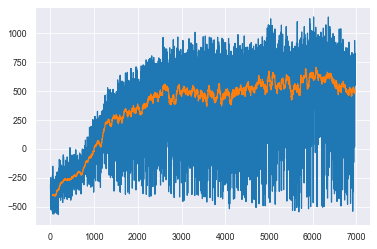

In [30]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=1e-6
agent_config['structure_actor']=[256,128]
agent_config['alpha_critic']=1e-3
agent_config['structure_critic']=[256,128]
agent=A2C(agent_config)

Iter=5000
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    gamma=1
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a[0])
        agent.update_paras(s.reshape(1,-1),a,r,sp.reshape(1,-1),done,gamma)
        gamma*=agent.gamma
        s = sp
        G+=r
    G_log.append(G)
    if len(G_log)%50==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show() 
        
        
plt.plot(G_log)
plt.plot(pd.DataFrame(G_log).rolling(50).mean())
plt.show()            

In [29]:
s=env.reset()
env.render()
done=False
G=0
while not done:
    a = agent.get_actions(s.reshape(1,-1))
    s, r, done, info = env.step(a[0])
    env.render() 
    G+=r
env.close()    
G

Creating window glfw


657.2588871989959

In [31]:
T.save(agent.actor.state_dict(), "HalfCheetah_actor")
# agent.actor.load_state_dict(torch.load("CartP_actor"))
# agent.actor.eval()

In [34]:
agent.critic.save("HalfCheetah_critic.h5")

In [ ]:
# # load model
# model = load_model('model.h5')
# # summarize model.
# model.summary()